In [50]:
import numpy as np
from utils import *
from viz import *
from metrics import *
from sklearn.metrics import normalized_mutual_info_score
%matplotlib inline

In [ ]:
gt = np.repeat(range(2) + range(2), 30)
viz_temporal_clusterings([gt], labels=['Ground Truth'])

In [ ]:
preds = [np.repeat([0, 3, 4, 1, 5, 6] * 2, [10, 10, 10, 10, 10, 10] * 2), 
         np.repeat([0, 3, 4, 1, 5, 6] + [4, 0, 3, 1, 5, 6], [10, 10, 10, 10, 10, 10] * 2),
         np.repeat([0, 3, 4, 1, 5, 6] + [3, 0, 4, 1, 5, 6], [10, 10, 10, 10, 10, 10] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [3, 0, 4, 3, 0, 4, 3, 0, 4, 3, 0, 4, 3, 0, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] * 2)]
pred_labels = ['Prediction 1 (repeated structure)', 
               'Prediction 2 (some repeated structure)',
               'Prediction 3 (some repeated structure)',
               'Prediction 4 (no repeated structure)',
               'Prediction 5 (no repeated structure)',
               'Prediction 6 (no repeated structure)']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_tss = [temporal_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]
preds_nmi = [normalized_mutual_info_score(gt, e) for e in preds]
preds_munkres = [munkres_score([gt], [e]) for e in preds]

for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tTemporal Structure Score: %1.2f \n\tNormalized Mutual Information Score: %1.2f\n'
          '\tMunkres Score: %1.2f' % (preds_tss[i], preds_nmi[i], preds_munkres[i]))

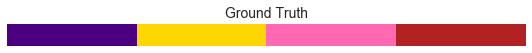

In [59]:
gt = np.repeat(range(4),20)
viz_temporal_clusterings([gt], labels=['Ground Truth'])

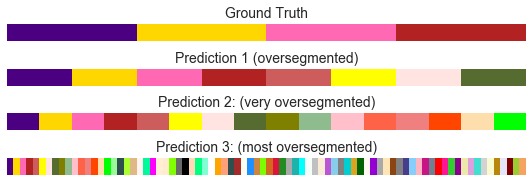

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.67 
	Label Agnostic Segmentation Score: 0.80 
Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.50 
	Label Agnostic Segmentation Score: 0.67 
Scores for Prediction 3
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.32 
	Label Agnostic Segmentation Score: 0.48 


In [60]:
pred_oversegmented_1 = np.repeat(range(8),10)
pred_oversegmented_2 = np.repeat(range(16),5)
pred_oversegmented_3 = np.repeat(range(80),1)
viz_temporal_clusterings([gt, pred_oversegmented_1, pred_oversegmented_2, pred_oversegmented_3], \
                         labels=['Ground Truth', 'Prediction 1 (oversegmented)', \
                                 'Prediction 2: (very oversegmented)', \
                                 'Prediction 3: (most oversegmented)'])
p1_lass_u = label_agnostic_undersegmentation_score(gt, pred_oversegmented_1)
p1_lass_o = label_agnostic_oversegmentation_score(gt, pred_oversegmented_1) 
p1_lass = label_agnostic_segmentation_score(gt, pred_oversegmented_1)
p2_lass_u = label_agnostic_undersegmentation_score(gt, pred_oversegmented_2)
p2_lass_o = label_agnostic_oversegmentation_score(gt, pred_oversegmented_2) 
p2_lass = label_agnostic_segmentation_score(gt, pred_oversegmented_2)
p3_lass_u = label_agnostic_undersegmentation_score(gt, pred_oversegmented_3)
p3_lass_o = label_agnostic_oversegmentation_score(gt, pred_oversegmented_3) 
p3_lass = label_agnostic_segmentation_score(gt, pred_oversegmented_3)
print('Scores for Prediction 1')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p1_lass_u, p1_lass_o, p1_lass))
print('Scores for Prediction 2')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p2_lass_u, p2_lass_o, p2_lass))
print('Scores for Prediction 3')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p3_lass_u, p3_lass_o, p3_lass))

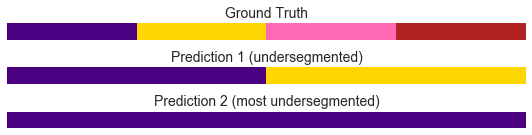

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 0.50 
	Label Agnostic Oversegmentation Score: 1.00 
	Label Agnostic Segmentation Score: 0.67 
Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 0.00 
	Label Agnostic Oversegmentation Score: 1.00 
	Label Agnostic Segmentation Score: 0.00 


In [61]:
pred_undersegmented_1 = np.repeat(range(2),40)
pred_undersegmented_2 = np.repeat(range(1),80)
viz_temporal_clusterings([gt, pred_undersegmented_1, pred_undersegmented_2], \
                         labels=['Ground Truth', 
                                 'Prediction 1 (undersegmented)', \
                                 'Prediction 2 (most undersegmented)'])
p1_lass_u = label_agnostic_undersegmentation_score(gt, pred_undersegmented_1)
p1_lass_o = label_agnostic_oversegmentation_score(gt, pred_undersegmented_1) 
p1_lass = label_agnostic_segmentation_score(gt, pred_undersegmented_1)
p2_lass_u = label_agnostic_undersegmentation_score(gt, pred_undersegmented_2)
p2_lass_o = label_agnostic_oversegmentation_score(gt, pred_undersegmented_2) 
p2_lass = label_agnostic_segmentation_score(gt, pred_undersegmented_2)
print('Scores for Prediction 1')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p1_lass_u, p1_lass_o, p1_lass))
print('Scores for Prediction 2')
print('\tLabel Agnostic Undersegmentation Score: %1.2f \n\tLabel Agnostic Oversegmentation Score: %1.2f \n\tLabel Agnostic Segmentation Score: %1.2f ' % (p2_lass_u, p2_lass_o, p2_lass))

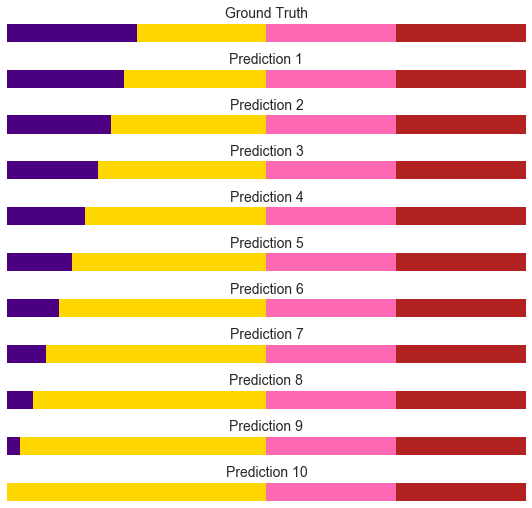

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 0.94 
	Label Agnostic Oversegmentation Score: 0.94 
	Label Agnostic Segmentation Score: 0.94 
	Normalized Mutual Information Score: 0.94 
	Munkres Score: 0.97 

Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 0.90 
	Label Agnostic Oversegmentation Score: 0.91 
	Label Agnostic Segmentation Score: 0.91 
	Normalized Mutual Information Score: 0.91 
	Munkres Score: 0.95 

Scores for Prediction 3
	Label Agnostic Undersegmentation Score: 0.87 
	Label Agnostic Oversegmentation Score: 0.89 
	Label Agnostic Segmentation Score: 0.88 
	Normalized Mutual Information Score: 0.88 
	Munkres Score: 0.93 

Scores for Prediction 4
	Label Agnostic Undersegmentation Score: 0.85 
	Label Agnostic Oversegmentation Score: 0.87 
	Label Agnostic Segmentation Score: 0.86 
	Normalized Mutual Information Score: 0.86 
	Munkres Score: 0.90 

Scores for Prediction 5
	Label Agnostic Undersegmentation Score: 0.83 
	Label Agnostic Oversegme

In [62]:
preds = [np.repeat(range(4), [20 - i, 20 + i, 20, 20]) for i in range(2, 21, 2)]
pred_labels = ['Prediction %d' % (i+1) for i in range(10)]
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_lass_u = [label_agnostic_undersegmentation_score(gt, e) for e in preds]
preds_lass_o = [label_agnostic_oversegmentation_score(gt, e) for e in preds]
preds_lass = [label_agnostic_segmentation_score(gt, e) for e in preds]
for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tLabel Agnostic Undersegmentation Score: %1.2f \n'
          '\tLabel Agnostic Oversegmentation Score: %1.2f \n'
          '\tLabel Agnostic Segmentation Score: %1.2f \n' % (preds_lass_u[i], preds_lass_o[i], preds_lass[i]))

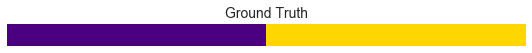

In [21]:
gt = np.repeat(range(2),30)
viz_temporal_clusterings([gt], labels=['Ground Truth'])

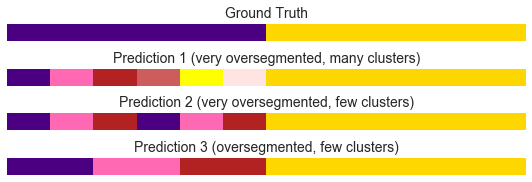

Scores for Prediction 1
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.44 
	Label Agnostic Segmentation Score: 0.61 
	Segmental Completeness Score: 0.44 
	Segmental Homogeneity Score: 1.00 
	Segment Structure Score: 0.61 

Scores for Prediction 2
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.44 
	Label Agnostic Segmentation Score: 0.61 
	Segmental Completeness Score: 0.56 
	Segmental Homogeneity Score: 1.00 
	Segment Structure Score: 0.66 

Scores for Prediction 3
	Label Agnostic Undersegmentation Score: 1.00 
	Label Agnostic Oversegmentation Score: 0.56 
	Label Agnostic Segmentation Score: 0.72 
	Segmental Completeness Score: 0.56 
	Segmental Homogeneity Score: 1.00 
	Segment Structure Score: 0.72 



In [23]:
preds = [np.repeat([0,2,3,4,5,6,1], [5, 5, 5, 5, 5, 5, 30]), 
         np.repeat([0,2,3,0,2,3,1], [5, 5, 5, 5, 5, 5, 30]),
         np.repeat([0,2,3,1], [10, 10, 10, 30])]
pred_labels = ['Prediction 1 (very oversegmented, many clusters)', 
               'Prediction 2 (very oversegmented, few clusters)',
               'Prediction 3 (oversegmented, few clusters)']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_lass_u = [label_agnostic_undersegmentation_score(gt, e) for e in preds]
preds_lass_o = [label_agnostic_oversegmentation_score(gt, e) for e in preds]
preds_lass = [label_agnostic_segmentation_score(gt, e) for e in preds]
preds_seg_com = [segment_completeness_score(gt, e) for e in preds]
preds_seg_hom = [segment_homogeneity_score(gt, e) for e in preds]
preds_sss = [segment_structure_score(gt, e) for e in preds]
for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tLabel Agnostic Undersegmentation Score: %1.2f \n'
          '\tLabel Agnostic Oversegmentation Score: %1.2f \n'
          '\tLabel Agnostic Segmentation Score: %1.2f \n'
          '\tSegmental Completeness Score: %1.2f \n'
          '\tSegmental Homogeneity Score: %1.2f \n'
          '\tSegment Structure Score: %1.2f \n' % (preds_lass_u[i], preds_lass_o[i], preds_lass[i], preds_seg_com[i], preds_seg_hom[i], preds_sss[i]))

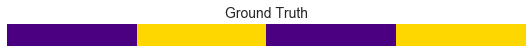

In [74]:
gt = np.repeat(range(2) + range(2), 30)
viz_temporal_clusterings([gt], labels=['Ground Truth'])

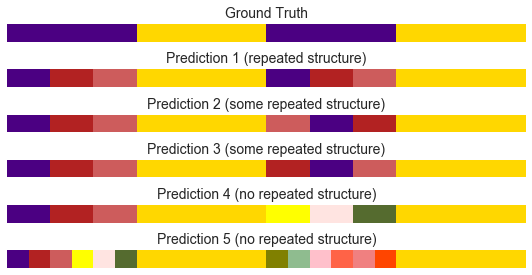

Scores for Prediction 1
	Repeated Structure Score: 1.00 
	Segment Structure Score: 0.79 
	Temporal Structure Score: 0.88 

Scores for Prediction 2
	Repeated Structure Score: 0.92 
	Segment Structure Score: 0.79 
	Temporal Structure Score: 0.85 

Scores for Prediction 3
	Repeated Structure Score: 0.83 
	Segment Structure Score: 0.79 
	Temporal Structure Score: 0.81 

Scores for Prediction 4
	Repeated Structure Score: 0.75 
	Segment Structure Score: 0.80 
	Temporal Structure Score: 0.78 

Scores for Prediction 5
	Repeated Structure Score: 0.75 
	Segment Structure Score: 0.72 
	Temporal Structure Score: 0.73 



In [75]:
preds = [np.repeat([0, 3, 4, 1] * 2, [10, 10, 10, 30] * 2), 
         np.repeat([0, 3, 4, 1] + [4, 0, 3, 1], [10, 10, 10, 30] * 2),
         np.repeat([0, 3, 4, 1] + [3, 0, 4, 1], [10, 10, 10, 30] * 2),
         np.repeat([0, 3, 4, 1] + [5, 6, 7, 1], [10, 10, 10, 30] * 2),
         np.repeat([0, 3, 4, 5, 6, 7, 1] + [8, 9, 10, 11, 12, 13, 1], [5, 5, 5, 5, 5, 5, 30] * 2)]
pred_labels = ['Prediction 1 (repeated structure)', 
               'Prediction 2 (some repeated structure)',
               'Prediction 3 (some repeated structure)',
               'Prediction 4 (no repeated structure)',
               'Prediction 5 (no repeated structure)']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_rss = [repeated_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]
preds_sss = [segment_structure_score(gt, e) for e in preds]
preds_tss = [temporal_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]

for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tRepeated Structure Score: %1.2f \n\tSegment Structure Score: %1.2f \n'
          '\tTemporal Structure Score: %1.2f \n' % (preds_rss[i], preds_sss[i], preds_tss[i]))

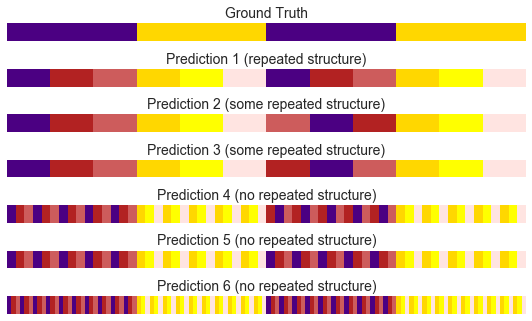

Scores for Prediction 1
	Temporal Structure Score: 0.79 
	Normalized Mutual Information Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 2
	Temporal Structure Score: 0.76 
	Normalized Mutual Information Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 3
	Temporal Structure Score: 0.73 
	Normalized Mutual Information Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 4
	Temporal Structure Score: 0.62 
	Normalized Mutual Information Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 5
	Temporal Structure Score: 0.69 
	Normalized Mutual Information Score: 0.62
	Munkres Score: 0.33
Scores for Prediction 6
	Temporal Structure Score: 0.65 
	Normalized Mutual Information Score: 0.62
	Munkres Score: 0.33


In [77]:
preds = [np.repeat([0, 3, 4, 1, 5, 6] * 2, [10, 10, 10, 10, 10, 10] * 2), 
         np.repeat([0, 3, 4, 1, 5, 6] + [4, 0, 3, 1, 5, 6], [10, 10, 10, 10, 10, 10] * 2),
         np.repeat([0, 3, 4, 1, 5, 6] + [3, 0, 4, 1, 5, 6], [10, 10, 10, 10, 10, 10] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [3, 0, 4, 3, 0, 4, 3, 0, 4, 3, 0, 4, 3, 0, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] * 2),
         np.repeat([0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6] + 
                   [0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 0, 3, 4, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6, 1, 5, 6], 
                   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] * 2)]
pred_labels = ['Prediction 1 (repeated structure)', 
               'Prediction 2 (some repeated structure)',
               'Prediction 3 (some repeated structure)',
               'Prediction 4 (no repeated structure)',
               'Prediction 5 (no repeated structure)',
               'Prediction 6 (no repeated structure)']
viz_temporal_clusterings([gt] + preds, labels=['Ground Truth'] + pred_labels)
preds_tss = [temporal_structure_score(gt, e, similarity_fn=heaviest_common_substring) for e in preds]
preds_nmi = [normalized_mutual_info_score(gt, e) for e in preds]
preds_munkres = [munkres_score([gt], [e]) for e in preds]

for i in range(len(preds)):
    print('Scores for Prediction %d' % (i+1))
    print('\tTemporal Structure Score: %1.2f \n\tNormalized Mutual Information Score: %1.2f\n'
          '\tMunkres Score: %1.2f' % (preds_tss[i], preds_nmi[i], preds_munkres[i]))